In [2]:
push!(LOAD_PATH, "../src/")
include("../src/PhysicalConstants.jl")

using DifferentialEquations
using Sundials
using NeutronStar
using Setup
using HeatCapacity
using NeutrinoLum
using PhotonLum
using SuperfluidGaps
using SpinDown
using LSODA

In [31]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [79]:
function heating(model::ModelParams, core::StarCoreParams, env::EnvelopeParams, var::StarVariables, solver::String,
                 tspan::Tuple{Float64,Float64}, reltol=1e-10, abstol=1e-10)
    
    #u = [Tinf, eta_e_inf, eta_mu_inf]
    function f(du,u,p,t)
        var.t = t #yr
        var.Tinf = u[1]
        var.eta_e_inf = u[2] #erg
        var.eta_mu_inf = u[3] #erg
        set_Tlocal(core, var)
        set_vn(model, core, var)
        set_vp(model, core, var)
        set_Omega(model, var)
        set_Omega_dot(model, var)
        #Heat capacity
        C = get_Ce(model, core, var) + get_Cmu(model, core, var) + get_Cn(model, core, var) + get_Cp(model, core, var)
        #Neutrino luminosity
        Lnu = L_murca_n_e(model, core, var, false) + L_murca_n_mu(model, core, var, false) + L_murca_p_e(model, core, var, false) + L_murca_p_mu(model, core, var, false)
        if lowercase(model.SFtype_n) != "normal"
            Lnu += L_PBF_n(model, core, var)
        end
        if lowercase(model.SFtype_p) != "normal"
            Lnu += L_PBF_p(model, core, var)
        end
        #Do not forget yrTosec!
        Rate_e = Rate_volume_murca_n_e(model, core, var, false) + Rate_volume_murca_p_e(model, core, var, false)
        Rate_mu = Rate_volume_murca_n_mu(model, core, var, false) + Rate_volume_murca_p_mu(model, core, var, false)
        @show t
        @show model.Znpe * Rate_e
        @show  model.Znp*Rate_mu
        @show 2*model.Wnpe*var.Omega*var.Omega_dot
        du[1] = (-Lnu/C - L_photon(model, env, var)/C + var.eta_e_inf*Rate_e/C + var.eta_mu_inf*Rate_mu/C) * yrTosec
        du[2] = (-model.Znpe * Rate_e - model.Znp*Rate_mu + 2*model.Wnpe*var.Omega*var.Omega_dot) * yrTosec
        du[3] = (-model.Znp * Rate_e - model.Znpmu*Rate_mu + 2*model.Wnpmu*var.Omega*var.Omega_dot) *yrTosec
        #return [du1, du2, du3]
    end

    u0 = [var.Tinf, var.eta_e_inf, var.eta_mu_inf]
    set_vn(model, core, var)
    set_vp(model, core, var)
    set_Omega(model, var)
    set_Omega_dot(model, var)

    prob = ODEProblem(f, u0, tspan)
    #solver = CVODE_Adams()
    solvers = Dict("CVODE_BDF"=>CVODE_BDF(), 
                    "CVODE_Adams"=>CVODE_Adams(),
                    "ARKODE"=>ARKODE())
    sol = solve(prob, solvers[solver], reltol, abstol)

    return sol
    
end

heating (generic function with 6 methods)

In [89]:
model, core, env, var = setup("../src/sample.ini");

In [90]:
sol = heating(model, core, env, var, "ARKODE", (var.t,1e9), 1e-10, 1e-10);

t = 1.0
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712544e-21
t = 1.0
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712544e-21
t = 1.0000005336679532
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712455e-21
t = 1.0000005336679532
model.Znpe * Rate_e = 4.606549386276981e-31
model.Znp * Rate_mu = 1.2112782397844487e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712455e-21
t = 1.0000005336679532
model.Znpe * Rate_e = 1.861259936328613e-16
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712455e-21
t = 1.0000005336679532
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 4.894126753907507e-19
2 * model.Wnpe * var

t = 1.0000003669774296
model.Znpe * Rate_e = 3.1786923970871727e-21
model.Znp * Rate_mu = 2.772661424479282e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712482e-21
t = 1.0000004671208822
model.Znpe * Rate_e = 3.1938638777060015e-21
model.Znp * Rate_mu = 2.395882127930278e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712469e-21
t = 1.0000004671208822
model.Znpe * Rate_e = 2.989208845042122e-21
model.Znp * Rate_mu = 3.0686141176997765e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712469e-21
t = 1.0000004671208822
model.Znpe * Rate_e = 3.1906780171148127e-21
model.Znp * Rate_mu = 3.0391250106600413e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712469e-21
t = 1.0000004671208822
model.Znpe * Rate_e = 3.2595718518119334e-21
model.Znp * Rate_mu = 3.041924920050012e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712469e-21
t = 1.0000005507590302
model.Znpe * Rate_e = 3.2920959291120623e-21
model.Znp * Rate_mu = 3.044917426750

model.Znp * Rate_mu = 4.364092947608698e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947121904e-21
t = 1.0000021015305596
model.Znpe * Rate_e = 3.2431045518128214e-21
model.Znp * Rate_mu = 4.1241163751773996e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712201e-21
t = 1.0000021015305596
model.Znpe * Rate_e = 3.0996130167323485e-21
model.Znp * Rate_mu = 4.444929497340812e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712201e-21
t = 1.0000021015305596
model.Znpe * Rate_e = 3.1854256880229955e-21
model.Znp * Rate_mu = 4.3643089090273707e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712201e-21
t = 1.0000021015305596
model.Znpe * Rate_e = 3.2250922835108637e-21
model.Znp * Rate_mu = 4.3577325756910026e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712201e-21
t = 1.0000026660674501
model.Znpe * Rate_e = 3.2431045518128214e-21
model.Znp * Rate_mu = 4.1241163751773996e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294

model.Znpe * Rate_e = 3.208222113210694e-21
model.Znp * Rate_mu = 4.876915961735373e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947093384e-21
t = 1.000019634885104
model.Znpe * Rate_e = 3.244403481252281e-21
model.Znp * Rate_mu = 4.869385845583135e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947093384e-21
t = 1.0000235041446541
model.Znpe * Rate_e = 3.314804889552643e-21
model.Znp * Rate_mu = 4.8188264652001196e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947087065e-21
t = 1.0000235041446541
model.Znpe * Rate_e = 3.010735784442142e-21
model.Znp * Rate_mu = 5.0340679251677056e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947087065e-21
t = 1.0000235041446541
model.Znpe * Rate_e = 3.1245645316877412e-21
model.Znp * Rate_mu = 4.859077328282907e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947087065e-21
t = 1.0000235041446541
model.Znpe * Rate_e = 3.1929570640573375e-21
model.Znp * Rate_mu = 4.84055804584926e-23
2 * model.Wnpe 

model.Znp * Rate_mu = 4.8759533293005646e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946936684e-21
t = 1.000115589900966
model.Znpe * Rate_e = 2.9778528958746024e-21
model.Znp * Rate_mu = 5.129726981949317e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946936684e-21
t = 1.000115589900966
model.Znpe * Rate_e = 3.0956224214436473e-21
model.Znp * Rate_mu = 4.944303599373125e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946936684e-21
t = 1.000115589900966
model.Znpe * Rate_e = 3.1555621082309068e-21
model.Znp * Rate_mu = 4.925000757996479e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946936684e-21
t = 1.000100429501274
model.Znpe * Rate_e = 3.244093663318978e-21
model.Znp * Rate_mu = 4.8759533293005646e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294696144e-21
t = 1.000100429501274
model.Znpe * Rate_e = 3.083957030038038e-21
model.Znp * Rate_mu = 5.1485570325913056e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546929469614

t = 1.000126681391963
model.Znpe * Rate_e = 3.224620001117398e-21
model.Znp * Rate_mu = 4.883445598044291e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294691858e-21
t = 1.000126681391963
model.Znpe * Rate_e = 3.0905301335936405e-21
model.Znp * Rate_mu = 4.9804073324224045e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294691858e-21
t = 1.000126681391963
model.Znpe * Rate_e = 3.1756819738854013e-21
model.Znp * Rate_mu = 4.9051050940443703e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294691858e-21
t = 1.000126681391963
model.Znpe * Rate_e = 3.2069221262591576e-21
model.Znp * Rate_mu = 4.9008979852564295e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294691858e-21
t = 1.0001186701944664
model.Znpe * Rate_e = 3.224620001117398e-21
model.Znp * Rate_mu = 4.883445598044291e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294693165e-21
t = 1.0001186701944664
model.Znpe * Rate_e = 3.128805522933119e-21
model.Znp * Rate_mu = 4.968666885058127e-

model.Znp * Rate_mu = 4.89432280427593e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294651467e-21
t = 1.000374046254561
model.Znpe * Rate_e = 3.1072169373869857e-21
model.Znp * Rate_mu = 4.97803141278186e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294651467e-21
t = 1.000374046254561
model.Znpe * Rate_e = 3.187642261898895e-21
model.Znp * Rate_mu = 4.9110299038256807e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294651467e-21
t = 1.000374046254561
model.Znpe * Rate_e = 3.2154075940510906e-21
model.Znp * Rate_mu = 4.9076713311941616e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294651467e-21
t = 1.0003514982684758
model.Znpe * Rate_e = 3.2329696472852607e-21
model.Znp * Rate_mu = 4.89432280427593e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294655149e-21
t = 1.0003514982684758
model.Znpe * Rate_e = 3.1428410360158892e-21
model.Znp * Rate_mu = 4.968294722503083e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294655149e-21

model.Znp * Rate_mu = 5.126592270099822e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294549489e-21
t = 1.0009985680898184
model.Znpe * Rate_e = 3.1095989446172968e-21
model.Znp * Rate_mu = 4.9194655913331046e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294549489e-21
t = 1.0009985680898184
model.Znpe * Rate_e = 3.1850983745321206e-21
model.Znp * Rate_mu = 4.8981277985641e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294549489e-21
t = 1.0011516006027015
model.Znpe * Rate_e = 3.2522243679201475e-21
model.Znp * Rate_mu = 4.90015874674232e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692945245e-21
t = 1.0011516006027015
model.Znpe * Rate_e = 3.134098931029599e-21
model.Znp * Rate_mu = 5.0464337762321355e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692945245e-21
t = 1.0011516006027015
model.Znpe * Rate_e = 3.1801371191228796e-21
model.Znp * Rate_mu = 4.961059406029308e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692945245e-21
t 

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293997958e-21
t = 1.0043762411511958
model.Znpe * Rate_e = 3.052615703431256e-21
model.Znp * Rate_mu = 4.9719329891745894e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293997958e-21
t = 1.0043762411511958
model.Znpe * Rate_e = 3.2404503788260776e-21
model.Znp * Rate_mu = 4.899240033326443e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293997958e-21
t = 1.0043762411511958
model.Znpe * Rate_e = 3.240450668544926e-21
model.Znp * Rate_mu = 4.899240471352648e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293997958e-21
t = 1.0043762411511958
model.Znpe * Rate_e = 6.298001923820718e-21
model.Znp * Rate_mu = 4.899240033326443e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293997958e-21
t = 1.0043762411511958
model.Znpe * Rate_e = 3.2404503788260776e-21
model.Znp * Rate_mu = 5.703213971933347e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293997958e-21
t = 1.0043762411511958
model.Znpe * Rate

model.Znp * Rate_mu = 4.9327540034718176e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692921333236e-21
t = 1.0157955624319397
model.Znpe * Rate_e = 3.269628146409086e-21
model.Znp * Rate_mu = 4.928974915412848e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692921333236e-21
t = 1.019246160979391
model.Znpe * Rate_e = 3.303158820167456e-21
model.Znp * Rate_mu = 4.9002623142599607e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469291569882e-21
t = 1.019246160979391
model.Znpe * Rate_e = 3.0485084434967485e-21
model.Znp * Rate_mu = 5.067703731038833e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469291569882e-21
t = 1.019246160979391
model.Znpe * Rate_e = 3.142782957177482e-21
model.Znp * Rate_mu = 4.927585018952744e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469291569882e-21
t = 1.019246160979391
model.Znpe * Rate_e = 3.1983117632298986e-21
model.Znp * Rate_mu = 4.9127648986842705e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469291569882e

t = 1.053737197795402
model.Znpe * Rate_e = 3.211865966207907e-21
model.Znp * Rate_mu = 4.895580981165332e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692859379275e-21
t = 1.0697596447498174
model.Znpe * Rate_e = 3.248937880792395e-21
model.Znp * Rate_mu = 4.8972210227042074e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469283321658e-21
t = 1.0697596447498174
model.Znpe * Rate_e = 3.0395785431143083e-21
model.Znp * Rate_mu = 5.336815416494398e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469283321658e-21
t = 1.0697596447498174
model.Znpe * Rate_e = 3.0794322022388106e-21
model.Znp * Rate_mu = 5.1217077780825184e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469283321658e-21
t = 1.0697596447498174
model.Znpe * Rate_e = 3.248937880792395e-21
model.Znp * Rate_mu = 4.8972210227042074e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469283321658e-21
t = 1.0697596447498174
model.Znpe * Rate_e = 3.248938171270088e-21
model.Znp * Rate_mu = 4.89722146054990

t = 1.2021899461215004
model.Znpe * Rate_e = 3.2202053940976433e-21
model.Znp * Rate_mu = 5.0177157492469503e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469261697431e-21
t = 1.2021899461215004
model.Znpe * Rate_e = 3.2408549269229964e-21
model.Znp * Rate_mu = 5.0074094102048875e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469261697431e-21
t = 1.2725749749495672
model.Znpe * Rate_e = 3.216334636379272e-21
model.Znp * Rate_mu = 4.93196141943798e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469250204426e-21
t = 1.2725749749495672
model.Znpe * Rate_e = 3.0886813072720226e-21
model.Znp * Rate_mu = 5.0302393022420696e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469250204426e-21
t = 1.2725749749495672
model.Znpe * Rate_e = 3.173417582050787e-21
model.Znp * Rate_mu = 4.954227234381603e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469250204426e-21
t = 1.2725749749495672
model.Znpe * Rate_e = 3.1987619062898807e-21
model.Znp * Rate_mu = 4.9503995512773

model.Znp * Rate_mu = 4.904976590613049e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154691534151996e-21
t = 1.9695256077508934
model.Znpe * Rate_e = 3.29740786076577e-21
model.Znp * Rate_mu = 4.9065224247264543e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469136401019e-21
t = 1.9695256077508934
model.Znpe * Rate_e = 3.2077153365808714e-21
model.Znp * Rate_mu = 4.978719538200513e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469136401019e-21
t = 1.9695256077508934
model.Znpe * Rate_e = 3.2483039641579146e-21
model.Znp * Rate_mu = 4.937252359566884e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469136401019e-21
t = 1.9695256077508934
model.Znpe * Rate_e = 3.2672120120104068e-21
model.Znp * Rate_mu = 4.9338700619031163e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469136401019e-21
t = 2.177920832043357
model.Znpe * Rate_e = 3.29740786076577e-21
model.Znp * Rate_mu = 4.9065224247264543e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469102372663

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468845605388e-21
t = 4.2398347146474125
model.Znpe * Rate_e = 3.275769563870043e-21
model.Znp * Rate_mu = 4.9020992053692506e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154687656876956e-21
t = 4.2398347146474125
model.Znpe * Rate_e = 3.0497963979351792e-21
model.Znp * Rate_mu = 5.0358400387686384e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154687656876956e-21
t = 4.2398347146474125
model.Znpe * Rate_e = 3.160302238866716e-21
model.Znp * Rate_mu = 4.907396117363208e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154687656876956e-21
t = 4.2398347146474125
model.Znpe * Rate_e = 3.212248856542263e-21
model.Znp * Rate_mu = 4.897413281986302e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154687656876956e-21
t = 5.423826272981016
model.Znpe * Rate_e = 3.246844346533422e-21
model.Znp * Rate_mu = 4.898991350027076e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468572356576e-21
t = 5.423826272981016
model.Znpe * Ra

model.Znp * Rate_mu = 4.9233538046355494e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468280035964e-21
t = 7.214045937396602
model.Znpe * Rate_e = 3.229681955058963e-21
model.Znp * Rate_mu = 4.9219270346482247e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468280035964e-21
t = 8.426502149560566
model.Znpe * Rate_e = 3.228216052844206e-21
model.Znp * Rate_mu = 4.896661613081865e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154680820569604e-21
t = 8.426502149560566
model.Znpe * Rate_e = 3.0736403175312753e-21
model.Znp * Rate_mu = 5.0085113278059095e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154680820569604e-21
t = 8.426502149560566
model.Znpe * Rate_e = 3.1649049487343895e-21
model.Znp * Rate_mu = 4.917635533063344e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154680820569604e-21
t = 8.426502149560566
model.Znpe * Rate_e = 3.203056159588858e-21
model.Znp * Rate_mu = 4.9114390242858035e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468082056960

model.Znp * Rate_mu = 4.8993087913446714e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546524762225e-21
t = 25.785059715090547
model.Znpe * Rate_e = 3.2569231306149694e-21
model.Znp * Rate_mu = 4.8993931166593506e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546524762225e-21
t = 25.785059715090547
model.Znpe * Rate_e = 3.2434655217027967e-21
model.Znp * Rate_mu = 4.959384931357796e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546524762225e-21
t = 25.785059715090547
model.Znpe * Rate_e = 3.255751989219669e-21
model.Znp * Rate_mu = 4.953480801794851e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546524762225e-21
t = 32.99389647184251
model.Znpe * Rate_e = 3.2569231306149694e-21
model.Znp * Rate_mu = 4.8993087913446714e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546407051054e-21
t = 32.99389647184251
model.Znpe * Rate_e = 3.1374575570774017e-21
model.Znp * Rate_mu = 4.968155359527564e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546407051054e-21


t = 90.2202210913957
model.Znpe * Rate_e = 3.2243569227087777e-21
model.Znp * Rate_mu = 4.9906645962576633e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915454726195575e-21
t = 87.47703392704838
model.Znpe * Rate_e = 3.2389910990263657e-21
model.Znp * Rate_mu = 4.897556502659146e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154551741216164e-21
t = 87.47703392704838
model.Znpe * Rate_e = 3.1753370044559975e-21
model.Znp * Rate_mu = 5.054515648550922e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154551741216164e-21
t = 87.47703392704838
model.Znpe * Rate_e = 3.2368497926069904e-21
model.Znp * Rate_mu = 5.009128379108849e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154551741216164e-21
t = 114.90890557052163
model.Znpe * Rate_e = 3.2389910990263657e-21
model.Znp * Rate_mu = 4.897556502659146e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91545069486464e-21
t = 114.90890557052163
model.Znpe * Rate_e = 3.0915890739066598e-21
model.Znp * Rate_mu = 5.046382705458808

model.Znpe * Rate_e = 3.0884468898686154e-21
model.Znp * Rate_mu = 4.982073775138087e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154059725960434e-21
t = 388.7996646156158
model.Znpe * Rate_e = 3.1763253947640095e-21
model.Znp * Rate_mu = 4.892478293590943e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154059725960434e-21
t = 388.7996646156158
model.Znpe * Rate_e = 3.2134752199983896e-21
model.Znp * Rate_mu = 4.886396953678334e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154059725960434e-21
t = 363.76800567182755
model.Znpe * Rate_e = 3.266385579935122e-21
model.Znp * Rate_mu = 4.881228383206359e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91541005986012e-21
t = 363.76800567182755
model.Znpe * Rate_e = 3.1345152488067525e-21
model.Znp * Rate_mu = 4.969637804114899e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91541005986012e-21
t = 363.76800567182755
model.Znpe * Rate_e = 3.204394094874476e-21
model.Znp * Rate_mu = 4.905885629172033e-23
2 * model.Wnpe * va

t = 713.1639607330612
model.Znpe * Rate_e = 3.2135983860092106e-21
model.Znp * Rate_mu = 4.857408047139864e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915353009744026e-21
t = 713.1639607330612
model.Znpe * Rate_e = 3.1632158086486993e-21
model.Znp * Rate_mu = 4.8905559273013905e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915353009744026e-21
t = 713.1639607330612
model.Znpe * Rate_e = 3.204524106277772e-21
model.Znp * Rate_mu = 4.867372620772031e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915353009744026e-21
t = 703.709937428619
model.Znpe * Rate_e = 3.2135983860092106e-21
model.Znp * Rate_mu = 4.857408047139864e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915354553400688e-21
t = 703.709937428619
model.Znpe * Rate_e = 3.169496064368665e-21
model.Znp * Rate_mu = 4.891118976549981e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915354553400688e-21
t = 703.709937428619
model.Znpe * Rate_e = 3.2074205703967916e-21
model.Znp * Rate_mu = 4.870360068011477e-23
2 *

model.Znp * Rate_mu = 4.765151858595002e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915032331928557e-21
t = 2677.255302627263
model.Znpe * Rate_e = 3.0571199414064816e-21
model.Znp * Rate_mu = 4.765152284632431e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915032331928557e-21
t = 2677.255302627263
model.Znpe * Rate_e = 3.0571224689284377e-21
model.Znp * Rate_mu = 4.765151858595002e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915032331928557e-21
t = 2677.255302627263
model.Znpe * Rate_e = 3.0571196680786803e-21
model.Znp * Rate_mu = 4.765152595075622e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915032331928557e-21
t = 2677.255302627263
model.Znpe * Rate_e = 3.111808788087202e-21
model.Znp * Rate_mu = 4.76551876143917e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915032331928557e-21
t = 2677.255302627263
model.Znpe * Rate_e = 3.1649697128655442e-21
model.Znp * Rate_mu = 4.7420299347850927e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915032331928557e-21


model.Znp * Rate_mu = 4.5254295441143867e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.914412526246622e-21
t = 8106.091516518172
model.Znpe * Rate_e = 3.184423728059299e-21
model.Znp * Rate_mu = 4.573199258187551e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91414616903293e-21
t = 8106.091516518172
model.Znpe * Rate_e = 3.0025416584417603e-21
model.Znp * Rate_mu = 4.421824480233807e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91414616903293e-21
t = 8106.091516518172
model.Znpe * Rate_e = 3.0883138854690323e-21
model.Znp * Rate_mu = 4.352376144858753e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91414616903293e-21
t = 9342.051163717479
model.Znpe * Rate_e = 3.132451969694739e-21
model.Znp * Rate_mu = 4.3508219287559395e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.913944462208127e-21
t = 9342.051163717479
model.Znpe * Rate_e = 3.032240016973007e-21
model.Znp * Rate_mu = 4.3624933788234306e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.913944462208127e-21
t 

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910736037195895e-21
t = 29014.54805668485
model.Znpe * Rate_e = 2.880829903907184e-21
model.Znp * Rate_mu = 3.4403374170102025e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910736037195895e-21
t = 29014.54805668485
model.Znpe * Rate_e = 2.8808300661074767e-21
model.Znp * Rate_mu = 3.4403371095248886e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910736037195895e-21
t = 29014.54805668485
model.Znpe * Rate_e = 2.880829646345198e-21
model.Znp * Rate_mu = 3.4403372202226475e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910736037195895e-21
t = 29014.54805668485
model.Znpe * Rate_e = 2.772199414846313e-21
model.Znp * Rate_mu = 3.228053794998823e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910736037195895e-21
t = 29014.54805668485
model.Znpe * Rate_e = 2.8021433580686628e-21
model.Znp * Rate_mu = 3.2127063048858065e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910736037195895e-21
t = 29014.54805668485
model.Znpe * Rate_e 

model.Znp * Rate_mu = 1.0826661967070896e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9003511958007456e-21
t = 92855.68051450167
model.Znpe * Rate_e = 1.4555417195285352e-21
model.Znp * Rate_mu = 1.0810666036608804e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9003511958007456e-21
t = 115525.41386274685
model.Znpe * Rate_e = 1.8757566476867513e-21
model.Znp * Rate_mu = 1.559844076753578e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.89667353007583e-21
t = 115525.41386274685
model.Znpe * Rate_e = 1.0148992133161445e-21
model.Znp * Rate_mu = 7.88242543554166e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.89667353007583e-21
t = 115525.41386274685
model.Znpe * Rate_e = 1.0096505923730174e-21
model.Znp * Rate_mu = 7.199645123561132e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.89667353007583e-21
t = 115525.41386274685
model.Znpe * Rate_e = 1.02827914067186e-21
model.Znp * Rate_mu = 7.163031063249415e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.89667353007583e-2

model.Znp * Rate_mu = 1.8386971390769062e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8600300878379545e-21
t = 343168.2521465238
model.Znpe * Rate_e = 1.0897902039684644e-22
model.Znp * Rate_mu = 1.8386711800170424e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8600300878379545e-21
t = 338030.3566724729
model.Znpe * Rate_e = 1.277262351190118e-22
model.Znp * Rate_mu = 1.5300985003892651e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.860851418670179e-21
t = 338030.3566724729
model.Znpe * Rate_e = 1.0904073836264742e-22
model.Znp * Rate_mu = 1.811805553477232e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.860851418670179e-21
t = 338030.3566724729
model.Znpe * Rate_e = 1.097003142009804e-22
model.Znp * Rate_mu = 1.7961879921093818e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.860851418670179e-21
t = 338030.3566724729
model.Znpe * Rate_e = 1.098635080604e-22
model.Znp * Rate_mu = 1.7961556184700057e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.860851418670179e-2

model.Znp * Rate_mu = 3.283662020993246e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.812031626338878e-21
t = 646304.0851155259
model.Znpe * Rate_e = 8.255512370847483e-22
model.Znp * Rate_mu = 3.2812383662315296e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.812031626338878e-21
t = 697683.0398560347
model.Znpe * Rate_e = 5.321143973695129e-22
model.Znp * Rate_mu = 1.9777953298728198e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.803985083500841e-21
t = 697683.0398560347
model.Znpe * Rate_e = 1.2482495558771933e-21
model.Znp * Rate_mu = 5.277390850518191e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.803985083500841e-21
t = 697683.0398560347
model.Znpe * Rate_e = 1.2339742035595438e-21
model.Znp * Rate_mu = 5.2595932206917143e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.803985083500841e-21
t = 697683.0398560347
model.Znpe * Rate_e = 1.2342118507834647e-21
model.Znp * Rate_mu = 5.2594884595016475e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.803985083500841e-

model.Znpe * Rate_e = 2.2174825365730416e-21
model.Znp * Rate_mu = 1.1643159559515512e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7883546991996616e-21
t = 797953.918100583
model.Znpe * Rate_e = 2.2119298619994053e-21
model.Znp * Rate_mu = 1.1630779985084766e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7883546991996616e-21
t = 797953.918100583
model.Znpe * Rate_e = 2.2120336933643943e-21
model.Znp * Rate_mu = 1.1630862977219736e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7883546991996616e-21
t = 834153.672459394
model.Znpe * Rate_e = 2.037442755168616e-21
model.Znp * Rate_mu = 1.0217802207263529e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.782735484361327e-21
t = 834153.672459394
model.Znpe * Rate_e = 2.5815977707181558e-21
model.Znp * Rate_mu = 1.492535638029464e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.782735484361327e-21
t = 834153.672459394
model.Znpe * Rate_e = 2.560013449390661e-21
model.Znp * Rate_mu = 1.4870123027836814e-22
2 * model.Wnpe * var

model.Znpe * Rate_e = 3.502671861015549e-21
model.Znp * Rate_mu = 3.523518238534698e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.74928125978647e-21
t = 1.0513521986122597e6
model.Znpe * Rate_e = 3.5880591758479164e-21
model.Znp * Rate_mu = 4.37581345377369e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.74928125978647e-21
t = 1.0513521986122597e6
model.Znpe * Rate_e = 3.574118410593638e-21
model.Znp * Rate_mu = 4.351476363034674e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.74928125978647e-21
t = 1.0368722968687352e6
model.Znpe * Rate_e = 3.502671861015549e-21
model.Znp * Rate_mu = 3.523518238534698e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7514977084496546e-21
t = 1.0368722968687352e6
model.Znpe * Rate_e = 3.57051510368984e-21
model.Znp * Rate_mu = 4.1395137956670856e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7514977084496546e-21
t = 1.0368722968687352e6
model.Znpe * Rate_e = 3.559878929957134e-21
model.Znp * Rate_mu = 4.122640064527815e-22
2 * model.Wnp

t = 1.3298313457954e6
model.Znpe * Rate_e = 3.271675004529841e-21
model.Znp * Rate_mu = 8.655243732539832e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.707033580635315e-21
t = 1.3298313457954e6
model.Znpe * Rate_e = 3.2691525829381657e-21
model.Znp * Rate_mu = 8.63477321223554e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.707033580635315e-21
t = 1.323767482528106e6
model.Znpe * Rate_e = 3.383057686877311e-21
model.Znp * Rate_mu = 7.721225527846744e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.707945899929839e-21
t = 1.323767482528106e6
model.Znpe * Rate_e = 3.2816125169488213e-21
model.Znp * Rate_mu = 8.569189474682246e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.707945899929839e-21
t = 1.323767482528106e6
model.Znpe * Rate_e = 3.279337151012521e-21
model.Znp * Rate_mu = 8.550998009824734e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.707945899929839e-21
t = 1.3844061152010458e6
model.Znpe * Rate_e = 3.383057686877311e-21
model.Znp * Rate_mu = 7.721225527846744

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.610822419839284e-21
t = 1.9215431525835872e6
model.Znpe * Rate_e = 2.6611468245102117e-21
model.Znp * Rate_mu = 1.1985945155902287e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.619603449725482e-21
t = 1.9215431525835872e6
model.Znpe * Rate_e = 2.5383551155548148e-21
model.Znp * Rate_mu = 1.2437500432010402e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.619603449725482e-21
t = 1.9215431525835872e6
model.Znpe * Rate_e = 2.5270657890721136e-21
model.Znp * Rate_mu = 1.2373941020867929e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.619603449725482e-21
t = 1.9215431525835872e6
model.Znpe * Rate_e = 2.5255005594658485e-21
model.Znp * Rate_mu = 1.238035918185957e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.619603449725482e-21
t = 1.9063898423769816e6
model.Znpe * Rate_e = 2.6611468245102117e-21
model.Znp * Rate_mu = 1.1985945155902287e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.621803712105415e-21
t = 1.9063898423769816e6

model.Znp * Rate_mu = 1.2426858558140572e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.436957702184959e-21
t = 3.2058551088218014e6
model.Znpe * Rate_e = 2.2267984120241713e-21
model.Znp * Rate_mu = 1.2544973268920609e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.440165863338381e-21
t = 3.2058551088218014e6
model.Znpe * Rate_e = 2.205714277081641e-21
model.Znp * Rate_mu = 1.241451508295458e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.440165863338381e-21
t = 3.2058551088218014e6
model.Znpe * Rate_e = 2.204446164391272e-21
model.Znp * Rate_mu = 1.2437678714462483e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.440165863338381e-21
t = 3.4445886608042284e6
model.Znpe * Rate_e = 2.2267984120241713e-21
model.Znp * Rate_mu = 1.2544973268920609e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.408285105435659e-21
t = 3.4445886608042284e6
model.Znpe * Rate_e = 2.184712706692282e-21
model.Znp * Rate_mu = 1.2280590637666565e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.40

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.0713317793749788e-21
t = 6.368267355910276e6
model.Znpe * Rate_e = 1.9665728244819786e-21
model.Znp * Rate_mu = 1.1096485933391233e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.0513084618001907e-21
t = 6.368267355910276e6
model.Znpe * Rate_e = 1.9538092607238675e-21
model.Znp * Rate_mu = 1.1014752845012013e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.0513084618001907e-21
t = 6.368267355910276e6
model.Znpe * Rate_e = 1.952223756908991e-21
model.Znp * Rate_mu = 1.103133400755479e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.0513084618001907e-21
t = 6.723022162268627e6
model.Znpe * Rate_e = 1.9665728244819786e-21
model.Znp * Rate_mu = 1.1096485933391233e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.0118448214734976e-21
t = 6.723022162268627e6
model.Znpe * Rate_e = 1.9320470466614267e-21
model.Znp * Rate_mu = 1.085130316144443e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.0118448214734976e-21
t = 6.723022162268627e6
m

model.Znp * Rate_mu = 1.0174288603023665e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.8119306597868554e-21
t = 8.979571034815406e6
model.Znpe * Rate_e = 1.8217297813864524e-21
model.Znp * Rate_mu = 1.0290225035099644e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.7778445111220997e-21
t = 8.979571034815406e6
model.Znpe * Rate_e = 1.7859884617852213e-21
model.Znp * Rate_mu = 1.0010298454354232e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.7778445111220997e-21
t = 8.979571034815406e6
model.Znpe * Rate_e = 1.779694767787053e-21
model.Znp * Rate_mu = 1.005690146867237e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.7778445111220997e-21
t = 9.152645894233938e6
model.Znpe * Rate_e = 1.7775073903642326e-21
model.Znp * Rate_mu = 1.0043013928986224e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.7610333888030515e-21
t = 9.152645894233938e6
model.Znpe * Rate_e = 1.76812482942252e-21
model.Znp * Rate_mu = 9.976122871884281e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.761

model.Znpe * Rate_e = 1.6340571254954237e-21
model.Znp * Rate_mu = 9.23977311730355e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.5527164267408654e-21
t = 1.1402619066674853e7
model.Znpe * Rate_e = 1.6541512207548707e-21
model.Znp * Rate_mu = 9.352234593954294e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.5556944298951858e-21
t = 1.1402619066674853e7
model.Znpe * Rate_e = 1.6391278556014565e-21
model.Znp * Rate_mu = 9.234670159439392e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.5556944298951858e-21
t = 1.1402619066674853e7
model.Znpe * Rate_e = 1.6358149486345342e-21
model.Znp * Rate_mu = 9.249947723150793e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.5556944298951858e-21
t = 1.1748768785511917e7
model.Znpe * Rate_e = 1.6541512207548707e-21
model.Znp * Rate_mu = 9.352234593954294e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.526147047622303e-21
t = 1.1748768785511917e7
model.Znpe * Rate_e = 1.6252807352751233e-21
model.Znp * Rate_mu = 9.11694823147732e-22
2 * 

2 * model.Wnpe * var.Omega * var.Omega_dot = 2.3200071422544077e-21
t = 1.4344891676789895e7
model.Znpe * Rate_e = 1.4860121001828669e-21
model.Znp * Rate_mu = 8.40122733847733e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.3200071422544077e-21
t = 1.420643178925507e7
model.Znpe * Rate_e = 1.508803766264318e-21
model.Znp * Rate_mu = 8.53630387476311e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.3303534432359842e-21
t = 1.420643178925507e7
model.Znpe * Rate_e = 1.495518507267995e-21
model.Znp * Rate_mu = 8.426836869289212e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.3303534432359842e-21
t = 1.420643178925507e7
model.Znpe * Rate_e = 1.4919819271686408e-21
model.Znp * Rate_mu = 8.437279858098687e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.3303534432359842e-21
t = 1.4171816817371363e7
model.Znpe * Rate_e = 1.508803766264318e-21
model.Znp * Rate_mu = 8.53630387476311e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.3329508326317475e-21
t = 1.4171816817371363e7
model.

model.Znp * Rate_mu = 7.7799083261355195e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.149557029211106e-21
t = 1.6767939708649341e7
model.Znpe * Rate_e = 1.375273961883007e-21
model.Znp * Rate_mu = 7.782672315668189e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.149557029211106e-21
t = 1.7114089427486405e7
model.Znpe * Rate_e = 1.381901205555158e-21
model.Znp * Rate_mu = 7.8223923709265195e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.126748781136465e-21
t = 1.7114089427486405e7
model.Znpe * Rate_e = 1.3671194055692767e-21
model.Znp * Rate_mu = 7.695215620426095e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.126748781136465e-21
t = 1.7114089427486405e7
model.Znpe * Rate_e = 1.3625485121990122e-21
model.Znp * Rate_mu = 7.703389912795261e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.126748781136465e-21
t = 1.6975629539951578e7
model.Znpe * Rate_e = 1.381901205555158e-21
model.Znp * Rate_mu = 7.8223923709265195e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 2.1358

t = 1.9364062599927317e7
model.Znpe * Rate_e = 1.2971769378887337e-21
model.Znp * Rate_mu = 7.3448527368963035e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.9869678694127063e-21
t = 1.9364062599927317e7
model.Znpe * Rate_e = 1.279404655199702e-21
model.Znp * Rate_mu = 7.195216629605983e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.9869678694127063e-21
t = 1.9364062599927317e7
model.Znpe * Rate_e = 1.2739658494761852e-21
model.Znp * Rate_mu = 7.198857929365662e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.9869678694127063e-21
t = 1.9537137459345847e7
model.Znpe * Rate_e = 1.2705935837720065e-21
model.Znp * Rate_mu = 7.19503101772542e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.97679073457807e-21
t = 1.9537137459345847e7
model.Znpe * Rate_e = 1.2662530247881972e-21
model.Znp * Rate_mu = 7.158907501710959e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.97679073457807e-21
t = 1.9537137459345847e7
model.Znpe * Rate_e = 1.2648997317960356e-21
model.Znp * Rate_mu = 7.1

model.Znp * Rate_mu = 6.701275945696495e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.8494693161558173e-21
t = 2.1787110631786764e7
model.Znpe * Rate_e = 1.1956357089883975e-21
model.Znp * Rate_mu = 6.772156175264065e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.8513055815702214e-21
t = 2.1787110631786764e7
model.Znpe * Rate_e = 1.1881377195078086e-21
model.Znp * Rate_mu = 6.707649949336504e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.8513055815702214e-21
t = 2.1787110631786764e7
model.Znpe * Rate_e = 1.1855890627527673e-21
model.Znp * Rate_mu = 6.7076925200255e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.8513055815702214e-21
t = 2.2133260350623827e7
model.Znpe * Rate_e = 1.1956357089883975e-21
model.Znp * Rate_mu = 6.772156175264065e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.8330651608467767e-21
t = 2.2133260350623827e7
model.Znpe * Rate_e = 1.1806727084698688e-21
model.Znp * Rate_mu = 6.643165184154861e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.8

model.Znpe * Rate_e = 1.0925329159799432e-21
model.Znp * Rate_mu = 6.178280596860566e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.7044628813764038e-21
t = 2.459092335436698e7
model.Znpe * Rate_e = 1.1056237542623923e-21
model.Znp * Rate_mu = 6.263971831463724e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.7109750421789067e-21
t = 2.459092335436698e7
model.Znpe * Rate_e = 1.0986538547266695e-21
model.Znp * Rate_mu = 6.202507199093632e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.7109750421789067e-21
t = 2.459092335436698e7
model.Znpe * Rate_e = 1.0960470989967408e-21
model.Znp * Rate_mu = 6.201157296521796e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.7109750421789067e-21
t = 2.4556308382483274e7
model.Znpe * Rate_e = 1.1056237542623923e-21
model.Znp * Rate_mu = 6.263971831463724e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.7126089137970045e-21
t = 2.4556308382483274e7
model.Znpe * Rate_e = 1.0992805488340627e-21
model.Znp * Rate_mu = 6.208072358383833e-22
2 * 

2 * model.Wnpe * var.Omega * var.Omega_dot = 1.5962653391630828e-21
t = 2.715243127376125e7
model.Znpe * Rate_e = 1.0216008932195968e-21
model.Znp * Rate_mu = 5.785576884792354e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.5962653391630828e-21
t = 2.7498580992598314e7
model.Znpe * Rate_e = 1.02543859769856e-21
model.Znp * Rate_mu = 5.810973628147358e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.5816534967378691e-21
t = 2.7498580992598314e7
model.Znpe * Rate_e = 1.0172918108194723e-21
model.Znp * Rate_mu = 5.737837304246088e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.5816534967378691e-21
t = 2.7498580992598314e7
model.Znpe * Rate_e = 1.0139887758124052e-21
model.Znp * Rate_mu = 5.7347220822743115e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.5816534967378691e-21
t = 2.736012110506349e7
model.Znpe * Rate_e = 1.02543859769856e-21
model.Znp * Rate_mu = 5.810973628147358e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.5874740621294245e-21
t = 2.736012110506349e7
mod

t = 3.0094703883876294e7
model.Znpe * Rate_e = 9.536946852514169e-22
model.Znp * Rate_mu = 5.405464099589472e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.4781879761246527e-21
t = 3.0094703883876294e7
model.Znpe * Rate_e = 9.490358772186612e-22
model.Znp * Rate_mu = 5.362710425191857e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.4781879761246527e-21
t = 3.0094703883876294e7
model.Znpe * Rate_e = 9.469999745436506e-22
model.Znp * Rate_mu = 5.360102930895182e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.4781879761246527e-21
t = 3.0440853602713358e7
model.Znpe * Rate_e = 9.536946852514169e-22
model.Znp * Rate_mu = 5.405464099589472e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.4651636749746508e-21
t = 3.0440853602713358e7
model.Znpe * Rate_e = 9.44301989900036e-22
model.Znp * Rate_mu = 5.319633004833527e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.4651636749746508e-21
t = 3.0440853602713358e7
model.Znpe * Rate_e = 9.402369272077407e-22
model.Znp * Rate_mu = 5.314

2 * model.Wnpe * var.Omega * var.Omega_dot = 1.3727434484590861e-21
t = 3.289851660645651e7
model.Znpe * Rate_e = 8.892435603585725e-22
model.Znp * Rate_mu = 5.041036501026182e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.3774488892740733e-21
t = 3.289851660645651e7
model.Znpe * Rate_e = 8.848055386104564e-22
model.Znp * Rate_mu = 4.999566927571502e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.3774488892740733e-21
t = 3.289851660645651e7
model.Znpe * Rate_e = 8.82737650520474e-22
model.Znp * Rate_mu = 4.996334479865874e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.3774488892740733e-21
t = 3.2863901634572804e7
model.Znpe * Rate_e = 8.892435603585725e-22
model.Znp * Rate_mu = 5.041036501026182e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.3786290297465046e-21
t = 3.2863901634572804e7
model.Znpe * Rate_e = 8.852066097647242e-22
model.Znp * Rate_mu = 5.003331502828465e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.3786290297465046e-21
t = 3.2863901634572804e7
model.

t = 3.528694966643225e7
model.Znpe * Rate_e = 8.451083217108267e-22
model.Znp * Rate_mu = 4.79141500825096e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2995402658095427e-21
t = 3.528694966643225e7
model.Znpe * Rate_e = 8.377451429956298e-22
model.Znp * Rate_mu = 4.722172505382945e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2995402658095427e-21
t = 3.528694966643225e7
model.Znpe * Rate_e = 8.3421363102750695e-22
model.Znp * Rate_mu = 4.716021912821057e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2995402658095427e-21
t = 3.546002452585078e7
model.Znpe * Rate_e = 8.31126490684431e-22
model.Znp * Rate_mu = 4.712325768187105e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2941533107803423e-21
t = 3.546002452585078e7
model.Znpe * Rate_e = 8.293599945012135e-22
model.Znp * Rate_mu = 4.695659300358068e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2941533107803423e-21
t = 3.546002452585078e7
model.Znpe * Rate_e = 8.284781732426974e-22
model.Znp * Rate_mu = 4.694079253

t = 3.770999769829169e7
model.Znpe * Rate_e = 7.912058689952325e-22
model.Znp * Rate_mu = 4.486486224441558e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2270670128064066e-21
t = 3.770999769829169e7
model.Znpe * Rate_e = 7.880168826650838e-22
model.Znp * Rate_mu = 4.4558580839093165e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2270670128064066e-21
t = 3.770999769829169e7
model.Znpe * Rate_e = 7.863767117977608e-22
model.Znp * Rate_mu = 4.452660634450148e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2270670128064066e-21
t = 3.805614741712876e7
model.Znpe * Rate_e = 7.912058689952325e-22
model.Znp * Rate_mu = 4.486486224441558e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2172106222442295e-21
t = 3.805614741712876e7
model.Znpe * Rate_e = 7.847482224808315e-22
model.Znp * Rate_mu = 4.424835693009999e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.2172106222442295e-21
t = 3.805614741712876e7
model.Znpe * Rate_e = 7.814902437887073e-22
model.Znp * Rate_mu = 4.4184826

t = 4.0513810420871906e7
model.Znpe * Rate_e = 7.423106821329285e-22
model.Znp * Rate_mu = 4.209827199760044e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.150523958015211e-21
t = 4.0513810420871906e7
model.Znpe * Rate_e = 7.39222635078684e-22
model.Znp * Rate_mu = 4.1797198758708864e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.150523958015211e-21
t = 4.0513810420871906e7
model.Znpe * Rate_e = 7.375564497118415e-22
model.Znp * Rate_mu = 4.1761757229935516e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.150523958015211e-21
t = 4.04791954489882e7
model.Znpe * Rate_e = 7.423106821329285e-22
model.Znp * Rate_mu = 4.209827199760044e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.1514247820147594e-21
t = 4.04791954489882e7
model.Znpe * Rate_e = 7.395025234940042e-22
model.Znp * Rate_mu = 4.182457842315367e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.1514247820147594e-21
t = 4.04791954489882e7
model.Znpe * Rate_e = 7.379855919440142e-22
model.Znp * Rate_mu = 4.1792328284

2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0866876515616987e-21
t = 4.342146805910324e7
model.Znpe * Rate_e = 6.978200360715199e-22
model.Znp * Rate_mu = 3.9580472778199247e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0784703918896806e-21
t = 4.342146805910324e7
model.Znpe * Rate_e = 6.940622489804353e-22
model.Znp * Rate_mu = 3.9211033028715867e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0784703918896806e-21
t = 4.342146805910324e7
model.Znpe * Rate_e = 6.919603287966693e-22
model.Znp * Rate_mu = 3.9163159588222e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0784703918896806e-21
t = 4.3283008171568416e7
model.Znpe * Rate_e = 6.978200360715199e-22
model.Znp * Rate_mu = 3.9580472778199247e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0817460743274421e-21
t = 4.3283008171568416e7
model.Znpe * Rate_e = 6.950871114040084e-22
model.Znp * Rate_mu = 3.931029096743485e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0817460743274421e-21
t = 4.3283008171568416e7
mode

2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0234732314088163e-21
t = 4.584451609096269e7
model.Znpe * Rate_e = 6.548918710715207e-22
model.Znp * Rate_mu = 3.715002083028547e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0234732314088163e-21
t = 4.584451609096269e7
model.Znpe * Rate_e = 6.548902599450708e-22
model.Znp * Rate_mu = 3.7149963085772377e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.0234732314088163e-21
t = 4.619066580979975e7
model.Znpe * Rate_e = 6.5721946028421145e-22
model.Znp * Rate_mu = 3.728248938241618e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.015961198971322e-21
t = 4.619066580979975e7
model.Znpe * Rate_e = 6.5056164625098775e-22
model.Znp * Rate_mu = 3.688882444976504e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.015961198971322e-21
t = 4.619066580979975e7
model.Znpe * Rate_e = 6.505487608696655e-22
model.Znp * Rate_mu = 3.688833368756724e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 1.015961198971322e-21
t = 4.6052205922264926e7
model.Z

2 * model.Wnpe * var.Omega * var.Omega_dot = 9.16339830723048e-22
t = 5.110716466903373e7
model.Znpe * Rate_e = 5.964949927952595e-22
model.Znp * Rate_mu = 3.3790635176570917e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 9.176213387416394e-22
t = 5.110716466903373e7
model.Znpe * Rate_e = 5.88565531407028e-22
model.Znp * Rate_mu = 3.334496043960068e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 9.176213387416394e-22
t = 5.179963906910294e7
model.Znpe * Rate_e = 5.964949927952595e-22
model.Znp * Rate_mu = 3.3790635176570917e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 9.049260862452595e-22
t = 5.179963906910294e7
model.Znpe * Rate_e = 5.808466119374319e-22
model.Znp * Rate_mu = 3.2899602363459155e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 9.049260862452595e-22
t = 5.2117193348638326e7
model.Znpe * Rate_e = 5.795763143395344e-22
model.Znp * Rate_mu = 3.2844513884255863e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 8.991922499083107e-22
t = 5.2117193348638326e7
model.Znpe

t = 5.738033199079577e7
model.Znpe * Rate_e = 5.209141025635049e-22
model.Znp * Rate_mu = 2.9519304721760655e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 8.115822346713821e-22
t = 5.716113930274988e7
model.Znpe * Rate_e = 5.284257917392965e-22
model.Znp * Rate_mu = 2.9948552158190523e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 8.149703609232072e-22
t = 5.716113930274988e7
model.Znpe * Rate_e = 5.228988040997398e-22
model.Znp * Rate_mu = 2.96342894896118e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 8.149703609232072e-22
t = 5.710634113073841e7
model.Znpe * Rate_e = 5.284257917392965e-22
model.Znp * Rate_mu = 2.9948552158190523e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 8.158207075975112e-22
t = 5.710634113073841e7
model.Znpe * Rate_e = 5.233916606632013e-22
model.Znp * Rate_mu = 2.9662791973110356e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 8.158207075975112e-22
t = 5.765432285085313e7
model.Znpe * Rate_e = 5.284257917392965e-22
model.Znp * Rate_mu = 2.9948552158

t = 6.29576394682123e7
model.Znpe * Rate_e = 4.710894799842413e-22
model.Znp * Rate_mu = 2.6714471399115286e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 7.320147088313814e-22
t = 6.29576394682123e7
model.Znpe * Rate_e = 4.692511179161943e-22
model.Znp * Rate_mu = 2.6609348201014713e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 7.320147088313814e-22
t = 6.345428137155385e7
model.Znpe * Rate_e = 4.710894799842413e-22
model.Znp * Rate_mu = 2.6714471399115286e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 7.255030556626912e-22
t = 6.345428137155385e7
model.Znpe * Rate_e = 4.657280941665102e-22
model.Znp * Rate_mu = 2.639694987348516e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 7.255030556626912e-22
t = 6.325562461021723e7
model.Znpe * Rate_e = 4.710894799842413e-22
model.Znp * Rate_mu = 2.6714471399115286e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 7.280972501290065e-22
t = 6.325562461021723e7
model.Znpe * Rate_e = 4.671450116733946e-22
model.Znp * Rate_mu = 2.64824025493

model.Znpe * Rate_e = 4.290535030657545e-22
model.Znp * Rate_mu = 2.4330002707955964e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.687110809924935e-22
t = 6.857056037718879e7
model.Znpe * Rate_e = 4.320160375203912e-22
model.Znp * Rate_mu = 2.450689545326176e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.631940158904887e-22
t = 6.857056037718879e7
model.Znpe * Rate_e = 4.261824817513773e-22
model.Znp * Rate_mu = 2.4149411496393264e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.631940158904887e-22
t = 6.881051100656621e7
model.Znpe * Rate_e = 4.249051672904284e-22
model.Znp * Rate_mu = 2.410502505021029e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.604711860211312e-22
t = 6.881051100656621e7
model.Znpe * Rate_e = 4.234437833695423e-22
model.Znp * Rate_mu = 2.4019760979652137e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.604711860211312e-22
t = 6.929041226532108e7
model.Znpe * Rate_e = 4.249051672904284e-22
model.Znp * Rate_mu = 2.410502505021029e-22
2 * model.Wnpe

Excessive output truncated after 524306 bytes.

t = 7.286873272655886e7
model.Znpe * Rate_e = 3.9584261679954553e-22
model.Znp * Rate_mu = 2.245207546796539e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.168495925232431e-22
t = 7.334392079200555e7
model.Znpe * Rate_e = 3.983519101286616e-22
model.Znp * Rate_mu = 2.2603979478956493e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.120261640668382e-22
t = 7.334392079200555e7
model.Znpe * Rate_e = 3.9340092472249014e-22
model.Znp * Rate_mu = 2.2296471057220785e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.120261640668382e-22
t = 7.358115299964958e7
model.Znpe * Rate_e = 3.92137917132992e-22
model.Znp * Rate_mu = 2.2252623380290673e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.096392676325019e-22
t = 7.358115299964958e7
model.Znpe * Rate_e = 3.9089731412856114e-22
model.Znp * Rate_mu = 2.217924164249322e-22
2 * model.Wnpe * var.Omega * var.Omega_dot = 6.096392676325019e-22
t = 7.405561741493763e7
model.Znpe * Rate_e = 3.92137917132992e-22
model.Znp * Rate_mu = 2.225262338

In [91]:
T = map(u->u[1], sol.u);
eta_e = map(u->u[2]/kB, sol.u);
eta_mu = map(u->u[3]/kB, sol.u);

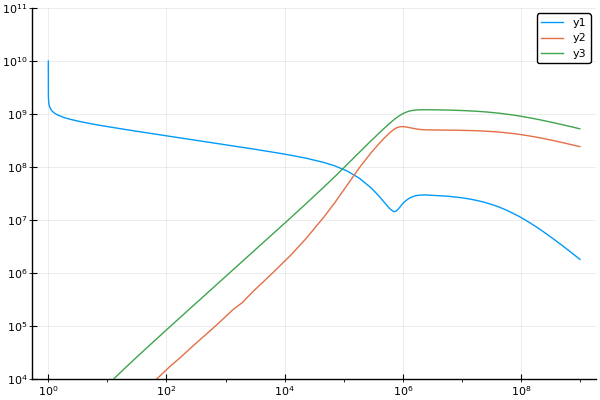

In [92]:
plot(sol.t, T, scale=:log10)
plot!(sol.t, eta_e, scale=:log10)
plot!(sol.t, eta_mu, scale=:log10)
ylims!(1e4,1e11)

In [102]:
model, core, env, var = setup("../src/sample2.ini");
sol = heating(model, core, env, var, "ARKODE", (var.t,1e10), 1e-10, 1e-10);

t = 1.0
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712544e-21
t = 1.0
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712544e-21
t = 1.0000016876062465
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712269e-21
t = 1.0000016876062465
model.Znpe * Rate_e = 4.606549386276981e-31
model.Znp * Rate_mu = 1.2112782397844487e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712269e-21
t = 1.0000016876062465
model.Znpe * Rate_e = 5.885820716417726e-16
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712269e-21
t = 1.0000016876062465
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.5476587699912339e-18
2 * model.Wnpe * va

t = 1.0000000791065429
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947125305e-21
t = 1.0000000791065429
model.Znpe * Rate_e = 2.1791621728356835e-21
model.Znp * Rate_mu = 1.1229300844647407e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947125305e-21
t = 1.0000000791065429
model.Znpe * Rate_e = 2.2883049815314675e-21
model.Znp * Rate_mu = 1.1334297253364173e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947125305e-21
t = 1.0000000580114647
model.Znpe * Rate_e = 4.6065489744193925e-31
model.Znp * Rate_mu = 1.2112781314877407e-33
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712534e-21
t = 1.0000000580114647
model.Znpe * Rate_e = 1.797719750741607e-21
model.Znp * Rate_mu = 8.80303334726801e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294712534e-21
t = 1.0000000580114647
model.Znpe * Rate_e = 1.8671896862084354e-21
model.Znp * Rate_mu = 8.87266565

model.Znp * Rate_mu = 3.349469242508089e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947124455e-21
t = 1.0000006007351605
model.Znpe * Rate_e = 3.2517533780871502e-21
model.Znp * Rate_mu = 3.3416329529112733e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947124455e-21
t = 1.0000005810528438
model.Znpe * Rate_e = 3.232641401908094e-21
model.Znp * Rate_mu = 2.8191549586041175e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947124485e-21
t = 1.0000005810528438
model.Znpe * Rate_e = 3.228073841665081e-21
model.Znp * Rate_mu = 3.31693111438456e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947124485e-21
t = 1.0000005810528438
model.Znpe * Rate_e = 3.253994943642158e-21
model.Znp * Rate_mu = 3.310595548330357e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947124485e-21
t = 1.0000007778760087
model.Znpe * Rate_e = 3.232641401908094e-21
model.Znp * Rate_mu = 2.8191549586041175e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546929471

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294711892e-21
t = 1.0000039961387306
model.Znpe * Rate_e = 3.1871523290876454e-21
model.Znp * Rate_mu = 4.5926155644948316e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294711892e-21
t = 1.0000036241030228
model.Znpe * Rate_e = 3.294371620152968e-21
model.Znp * Rate_mu = 4.4147206577767005e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947119535e-21
t = 1.0000036241030228
model.Znpe * Rate_e = 3.082475221820432e-21
model.Znp * Rate_mu = 4.708257118529717e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947119535e-21
t = 1.0000036241030228
model.Znpe * Rate_e = 3.174280787489773e-21
model.Znp * Rate_mu = 4.598777630804924e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947119535e-21
t = 1.0000036241030228
model.Znpe * Rate_e = 3.222612699818901e-21
model.Znp * Rate_mu = 4.5881405927226474e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692947119535e-21
t = 1.000003531094096
model.Znpe * 

model.Znpe * Rate_e = 3.264559676847372e-21
model.Znp * Rate_mu = 4.795644618096257e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294709936e-21
t = 1.0000159725500077
model.Znpe * Rate_e = 6.534413446177629e-19
model.Znp * Rate_mu = 4.7956441893322395e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294709936e-21
t = 1.0000159725500077
model.Znpe * Rate_e = 3.2645593849730072e-21
model.Znp * Rate_mu = 1.7575766498337854e-21
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294709936e-21
t = 1.0000159725500077
model.Znpe * Rate_e = 3.2434522395979573e-21
model.Znp * Rate_mu = 4.9066475941775617e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294709936e-21
t = 1.0000159725500077
model.Znpe * Rate_e = 3.2635413530743746e-21
model.Znp * Rate_mu = 4.895801349797885e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294709936e-21
t = 1.0000218207717355
model.Znpe * Rate_e = 3.2645593849730072e-21
model.Znp * Rate_mu = 4.7956441893322395e-23
2 * model.Wnpe

model.Znp * Rate_mu = 4.861022699876696e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294701092e-21
t = 1.0000701282270144
model.Znpe * Rate_e = 3.0848402146662807e-21
model.Znp * Rate_mu = 5.0261477341062065e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294701092e-21
t = 1.0000701282270144
model.Znpe * Rate_e = 3.2107165191843064e-21
model.Znp * Rate_mu = 4.8889898667562473e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294701092e-21
t = 1.0000701282270144
model.Znpe * Rate_e = 3.2611809567501178e-21
model.Znp * Rate_mu = 4.879317830868808e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294701092e-21
t = 1.0000785499522542
model.Znpe * Rate_e = 3.2932489910694535e-21
model.Znp * Rate_mu = 4.880794578211383e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294699717e-21
t = 1.0000785499522542
model.Znpe * Rate_e = 3.2065868622289588e-21
model.Znp * Rate_mu = 4.9536218502922955e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91546929469

model.Znpe * Rate_e = 3.1916545331238346e-21
model.Znp * Rate_mu = 5.244827103772209e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946493585e-21
t = 1.0003869555992002
model.Znpe * Rate_e = 3.262141009092384e-21
model.Znp * Rate_mu = 5.176997583077089e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946493585e-21
t = 1.0003869555992002
model.Znpe * Rate_e = 3.28468120185394e-21
model.Znp * Rate_mu = 5.1715531795706174e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692946493585e-21
t = 1.000639286830363
model.Znpe * Rate_e = 3.2456626421139602e-21
model.Znp * Rate_mu = 4.8926967211374897e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294608157e-21
t = 1.000639286830363
model.Znpe * Rate_e = 2.827832462671665e-21
model.Znp * Rate_mu = 5.41253429208293e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294608157e-21
t = 1.000639286830363
model.Znpe * Rate_e = 2.9512286495021975e-21
model.Znp * Rate_mu = 5.008797188155648e-23
2 * model.Wnpe * va

model.Znp * Rate_mu = 4.926151600966426e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294583753e-21
t = 1.0007887375072435
model.Znpe * Rate_e = 3.223651045814096e-21
model.Znp * Rate_mu = 4.92440886704186e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294583753e-21
t = 1.0007152398292536
model.Znpe * Rate_e = 3.228038807957568e-21
model.Znp * Rate_mu = 4.8958924876849637e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294595754e-21
t = 1.0007152398292536
model.Znpe * Rate_e = 3.186806111133096e-21
model.Znp * Rate_mu = 4.9908859429853934e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294595754e-21
t = 1.0007152398292536
model.Znpe * Rate_e = 3.2340445572012103e-21
model.Znp * Rate_mu = 4.9619956385407705e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294595754e-21
t = 1.000696865409756
model.Znpe * Rate_e = 3.228038807957568e-21
model.Znp * Rate_mu = 4.8958924876849637e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469294598754e

model.Znp * Rate_mu = 4.176408227572092e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293987603e-21
t = 1.0044396637925979
model.Znpe * Rate_e = 2.8858983792727575e-21
model.Znp * Rate_mu = 4.174768016884805e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293987603e-21
t = 1.0050420365120012
model.Znpe * Rate_e = 2.9061623015749127e-21
model.Znp * Rate_mu = 4.342910882107998e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692938892406e-21
t = 1.0050420365120012
model.Znpe * Rate_e = 2.534953761562642e-21
model.Znp * Rate_mu = 4.178591541828585e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692938892406e-21
t = 1.0050420365120012
model.Znpe * Rate_e = 2.6437697154248318e-21
model.Znp * Rate_mu = 3.96019874514665e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692938892406e-21
t = 1.0050420365120012
model.Znpe * Rate_e = 2.7319271608010024e-21
model.Znp * Rate_mu = 3.9550828699599563e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469293889

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469292969766e-21
t = 1.0106730619360638
model.Znpe * Rate_e = 2.3937372426150366e-21
model.Znp * Rate_mu = 2.7090187459635597e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469292969766e-21
t = 1.0127983430970375
model.Znpe * Rate_e = 2.644000942904981e-21
model.Znp * Rate_mu = 3.239053006115671e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469292622733e-21
t = 1.0127983430970375
model.Znpe * Rate_e = 1.8864275895863072e-21
model.Znp * Rate_mu = 2.2470130434046693e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469292622733e-21
t = 1.0127983430970375
model.Znpe * Rate_e = 2.0011033005582994e-21
model.Znp * Rate_mu = 2.2071419863155323e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469292622733e-21
t = 1.0138609836775243
model.Znpe * Rate_e = 2.0885686838677847e-21
model.Znp * Rate_mu = 2.216231898645209e-23
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469292449219e-21
t = 1.0138609836775243
model.Znpe * 

model.Znp * Rate_mu = 4.934389331880667e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692894901e-21
t = 1.0319830944811677
model.Znpe * Rate_e = 6.1601121432199e-22
model.Znp * Rate_mu = 4.87708429801588e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692894901e-21
t = 1.0319830944811677
model.Znpe * Rate_e = 6.255051846033449e-22
model.Znp * Rate_mu = 4.891391651237377e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692894901e-21
t = 1.0363480986738494
model.Znpe * Rate_e = 6.900477937808663e-22
model.Znp * Rate_mu = 5.454232175883246e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469288777348e-21
t = 1.0363480986738494
model.Znpe * Rate_e = 4.478151122429463e-22
model.Znp * Rate_mu = 3.717773452290694e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469288777348e-21
t = 1.0363480986738494
model.Znpe * Rate_e = 4.712464049640147e-22
model.Znp * Rate_mu = 3.679554463407842e-24
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469288777348e-21
t = 1.03

model.Znp * Rate_mu = 5.291516548958782e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469276115506e-21
t = 1.12924670959705
model.Znpe * Rate_e = 1.4670306673702e-23
model.Znp * Rate_mu = 8.324763262118466e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692736081586e-21
t = 1.12924670959705
model.Znpe * Rate_e = 6.200887067666491e-24
model.Znp * Rate_mu = 3.432310909664767e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692736081586e-21
t = 1.12924670959705
model.Znpe * Rate_e = 5.974046414781936e-24
model.Znp * Rate_mu = 3.2971826923877016e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692736081586e-21
t = 1.12924670959705
model.Znpe * Rate_e = 5.953443895578403e-24
model.Znp * Rate_mu = 3.2859579753430017e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692736081586e-21
t = 1.1369244162586523
model.Znpe * Rate_e = 5.5521210164909624e-24
model.Znp * Rate_mu = 3.066650574688406e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154692723544835e-21
t

t = 1.507597451947104
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469211828164e-21
t = 1.507597451947104
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469211828164e-21
t = 1.507597451947104
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469211828164e-21
t = 1.507597451947104
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469211828164e-21
t = 1.570559356765754
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469201547266e-21
t = 1.570559356765754
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469201547266e-21
t = 1.570559356765754
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469201547266e-21
t = 1.5705593

t = 2.5389953455030803
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469043413669e-21
t = 2.5389953455030803
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469043413669e-21
t = 2.5150583331909244
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469047322284e-21
t = 2.5150583331909244
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469047322284e-21
t = 2.5150583331909244
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469047322284e-21
t = 2.5150583331909244
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469047322284e-21
t = 2.754428456312483
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915469008236111e-21
t = 2.7

t = 4.843957390177567
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468667041962e-21
t = 4.843957390177567
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468667041962e-21
t = 5.685220861292606
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468529674088e-21
t = 5.685220861292606
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468529674088e-21
t = 5.685220861292606
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468529674088e-21
t = 5.685220861292606
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915468529674088e-21
t = 6.105852596850125
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154684609901574e-21
t = 6.105852

t = 41.230640797072816
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154627255551935e-21
t = 41.230640797072816
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154627255551935e-21
t = 41.230640797072816
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154627255551935e-21
t = 41.230640797072816
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154627255551935e-21
t = 52.798228604849925
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154608367167385e-21
t = 52.798228604849925
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154608367167385e-21
t = 52.798228604849925
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154608367167385e-21

t = 324.27044039640435
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154165091851924e-21
t = 324.27044039640435
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154165091851924e-21
t = 324.27044039640435
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9154165091851924e-21
t = 318.08541945929613
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91541751910232e-21
t = 318.08541945929613
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91541751910232e-21
t = 318.08541945929613
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.91541751910232e-21
t = 379.93562883037805
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.915407419948644e-21
t = 37

t = 3461.7256730919335
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.914904262212607e-21
t = 3461.7256730919335
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.914904262212607e-21
t = 3461.7256730919335
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.914904262212607e-21
t = 3371.5535334296014
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9149189830612e-21
t = 3371.5535334296014
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9149189830612e-21
t = 3371.5535334296014
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9149189830612e-21
t = 3371.5535334296014
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.9149189830612e-21
t = 4273.27493

t = 35839.49283013445
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.909623865649155e-21
t = 32637.750208703284
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910145552476156e-21
t = 32637.750208703284
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910145552476156e-21
t = 32637.750208703284
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910145552476156e-21
t = 32637.750208703284
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910145552476156e-21
t = 31837.31455334549
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910275990498246e-21
t = 31837.31455334549
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.910275990498246e-21
t = 31837

model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.872399583874248e-21
t = 265963.1150187906
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.872399583874248e-21
t = 320689.09663204063
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8636254845315766e-21
t = 320689.09663204063
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8636254845315766e-21
t = 320689.09663204063
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8636254845315766e-21
t = 320689.09663204063
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8636254845315766e-21
t = 298798.7039867406
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.867131542280466e-21
t = 298798.7039867406
model

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.823765871243917e-21
t = 571669.2372355973
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.823765871243917e-21
t = 571669.2372355973
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.823765871243917e-21
t = 566288.0703011845
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8246140026987415e-21
t = 566288.0703011845
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8246140026987415e-21
t = 566288.0703011845
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8246140026987415e-21
t = 620099.7396453115
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.816145367034235e-21
t = 620099.7396453115
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.819870789064296e-21
t = 596405.5013730009
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.819870789064296e-21
t = 619540.1749692202
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.816233283999075e-21
t = 619540.1749692202
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.816233283999075e-21
t = 619540.1749692202
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.816233283999075e-21
t = 631107.5117673298
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.814416479570527e-21
t = 631107.5117673298
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.814416479570527e-21
t = 631107.5117673298
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnp

model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.804458983434832e-21
t = 694652.5674270476
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.804458983434832e-21
t = 701863.3287433949
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8033315225975546e-21
t = 701863.3287433949
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8033315225975546e-21
t = 701863.3287433949
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.8033315225975546e-21
t = 716284.8513760894
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.801078103969465e-21
t = 716284.8513760894
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.801078103969465e-21
t = 716284.8513760894
model.Znpe * Rate_e = 0.0
model.Znp 

model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.778189826088655e-21
t = 863496.4976484287
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.778189826088655e-21
t = 878350.8458892754
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.775891780616229e-21
t = 878350.8458892754
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.775891780616229e-21
t = 878350.8458892754
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.775891780616229e-21
t = 908059.542370969
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 0.0
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7713019751431794e-21
t = 908059.542370969
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 2.284197281691292e-32
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7713019751431794e-21
t = 908059.542370969
model.Znpe * Rate_e = 

model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 6.343555199938195e-28
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.712245861482455e-21
t = 1.2952172640206153e6
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 6.343555861460241e-28
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.712245861482455e-21
t = 1.2952172640206153e6
model.Znpe * Rate_e = 6.2229806255757416e-27
model.Znp * Rate_mu = 2.179457205518116e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.712245861482455e-21
t = 1.2952172640206153e6
model.Znpe * Rate_e = 6.223057503224132e-27
model.Znp * Rate_mu = 2.17947233593196e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.712245861482455e-21
t = 1.2952172640206153e6
model.Znpe * Rate_e = 6.223057862631658e-27
model.Znp * Rate_mu = 2.179472406740126e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.712245861482455e-21
t = 1.2586571649209156e6
model.Znpe * Rate_e = 0.0
model.Znp * Rate_mu = 6.343555199938195e-28
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.7177631253742295e-2

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.699332589224865e-21
t = 1.3811064591581484e6
model.Znpe * Rate_e = 2.915925803060502e-26
model.Znp * Rate_mu = 4.2575065787044696e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.699332589224865e-21
t = 1.3811064591581484e6
model.Znpe * Rate_e = 2.915928909533612e-26
model.Znp * Rate_mu = 4.257509247325917e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.699332589224865e-21
t = 1.3811064591581484e6
model.Znpe * Rate_e = 2.9159288256022206e-26
model.Znp * Rate_mu = 4.257509178391895e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.699332589224865e-21
t = 1.4146885585509094e6
model.Znpe * Rate_e = 2.1902640121429298e-26
model.Znp * Rate_mu = 3.7961000916191955e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694301903159126e-21
t = 1.4146885585509094e6
model.Znpe * Rate_e = 4.4041043883058056e-26
model.Znp * Rate_mu = 5.330907254918036e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694301903159126e-21
t = 1.4146885585509094e6
mod

model.Znp * Rate_mu = 5.356905966196623e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694151141153153e-21
t = 1.4156960215326922e6
model.Znpe * Rate_e = 4.4255855894401534e-26
model.Znp * Rate_mu = 5.35690678218331e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694151141153153e-21
t = 1.4146885585509094e6
model.Znpe * Rate_e = 3.950559662609419e-26
model.Znp * Rate_mu = 5.0781936098180685e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694301903159126e-21
t = 1.4146885585509094e6
model.Znpe * Rate_e = 4.4042172750254396e-26
model.Znp * Rate_mu = 5.3310400434387046e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694301903159126e-21
t = 1.4146885585509094e6
model.Znpe * Rate_e = 4.404218341559056e-26
model.Znp * Rate_mu = 5.331040798519207e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.694301903159126e-21
t = 1.4247631883687377e6
model.Znpe * Rate_e = 3.950559662609419e-26
model.Znp * Rate_mu = 5.0781936098180685e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.69279

t = 1.4668931190235235e6
model.Znpe * Rate_e = 7.466899869238703e-26
model.Znp * Rate_mu = 7.665183194667381e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.686501875125926e-21
t = 1.4668931190235235e6
model.Znpe * Rate_e = 7.466900146669208e-26
model.Znp * Rate_mu = 7.665183345339828e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.686501875125926e-21
t = 1.4661840651196807e6
model.Znpe * Rate_e = 7.20136287552488e-26
model.Znp * Rate_mu = 7.184903100560065e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.686607651290143e-21
t = 1.4661840651196807e6
model.Znpe * Rate_e = 7.44241958789101e-26
model.Znp * Rate_mu = 7.640051900504689e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.686607651290143e-21
t = 1.4661840651196807e6
model.Znpe * Rate_e = 7.442419846070756e-26
model.Znp * Rate_mu = 7.640052039856634e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.686607651290143e-21
t = 1.4732746041581095e6
model.Znpe * Rate_e = 7.20136287552488e-26
model.Znp * Rate_mu = 7.1849031005

t = 1.5112367802092643e6
model.Znpe * Rate_e = 1.0015267976820172e-25
model.Znp * Rate_mu = 9.3037399584808e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.679895752981675e-21
t = 1.5112367802092643e6
model.Znpe * Rate_e = 1.1222992483787621e-25
model.Znp * Rate_mu = 9.919091151272623e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.679895752981675e-21
t = 1.5112367802092643e6
model.Znpe * Rate_e = 1.1222995289699793e-25
model.Znp * Rate_mu = 9.919092689216367e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.679895752981675e-21
t = 1.5112367802092643e6
model.Znpe * Rate_e = 1.1222995162333793e-25
model.Znp * Rate_mu = 9.919092625896642e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.679895752981675e-21
t = 1.5099463627609152e6
model.Znpe * Rate_e = 1.0015267976820172e-25
model.Znp * Rate_mu = 9.3037399584808e-27
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6800877427218644e-21
t = 1.5099463627609152e6
model.Znpe * Rate_e = 1.1158115711633572e-25
model.Znp * Rate_mu = 9.8617

t = 1.5176818995705864e6
model.Znpe * Rate_e = 1.1409684306542935e-25
model.Znp * Rate_mu = 1.0361156484154684e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.678937065848481e-21
t = 1.5176818995705864e6
model.Znpe * Rate_e = 1.1551868354892783e-25
model.Znp * Rate_mu = 1.0490275589555385e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.678937065848481e-21
t = 1.5169438772752534e6
model.Znpe * Rate_e = 1.1409684306542935e-25
model.Znp * Rate_mu = 1.0361156484154684e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6790468248795405e-21
t = 1.5169438772752534e6
model.Znpe * Rate_e = 1.1513805955182768e-25
model.Znp * Rate_mu = 1.045571065276903e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6790468248795405e-21
t = 1.51675937170142e6
model.Znpe * Rate_e = 1.1409684306542935e-25
model.Znp * Rate_mu = 1.0361156484154684e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6790742654047925e-21
t = 1.51675937170142e6
model.Znpe * Rate_e = 1.1504306942636265e-25
model.Znp * Rate_mu = 

model.Znp * Rate_mu = 1.0979938368359986e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.676182270493142e-21
t = 1.5362160319747443e6
model.Znpe * Rate_e = 1.3818025860867204e-25
model.Znp * Rate_mu = 1.200913045673935e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.676182270493142e-21
t = 1.5362160319747443e6
model.Znpe * Rate_e = 1.3818026698068552e-25
model.Znp * Rate_mu = 1.2009130833141124e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.676182270493142e-21
t = 1.5354619858703078e6
model.Znpe * Rate_e = 1.3319796454013463e-25
model.Znp * Rate_mu = 1.0979938368359986e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6762942867115135e-21
t = 1.5354619858703078e6
model.Znpe * Rate_e = 1.3772084336706584e-25
model.Znp * Rate_mu = 1.1352776221236992e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6762942867115135e-21
t = 1.5354619858703078e6
model.Znpe * Rate_e = 1.377208462618245e-25
model.Znp * Rate_mu = 1.1352776375952202e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 

model.Znp * Rate_mu = 1.229180650633914e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.674713403669731e-21
t = 1.5461070162211617e6
model.Znpe * Rate_e = 1.5127835036567078e-25
model.Znp * Rate_mu = 1.2543391851409897e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.674713403669731e-21
t = 1.5461070162211617e6
model.Znpe * Rate_e = 1.5127835041876666e-25
model.Znp * Rate_mu = 1.254339185411866e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.674713403669731e-21
t = 1.5553323392518866e6
model.Znpe * Rate_e = 1.4824413489602044e-25
model.Znp * Rate_mu = 1.229180650633914e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.673344184618033e-21
t = 1.5553323392518866e6
model.Znpe * Rate_e = 1.575056067708569e-25
model.Znp * Rate_mu = 1.3059731634161146e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.673344184618033e-21
t = 1.5553323392518866e6
model.Znpe * Rate_e = 1.5750560728189015e-25
model.Znp * Rate_mu = 1.3059731660119353e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.67

t = 1.5878109966230472e6
model.Znpe * Rate_e = 2.075872184943382e-25
model.Znp * Rate_mu = 1.6210956354690197e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.668529798993314e-21
t = 1.5878109966230472e6
model.Znpe * Rate_e = 2.07587425960354e-25
model.Znp * Rate_mu = 1.6210966339917935e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.668529798993314e-21
t = 1.5878109966230472e6
model.Znpe * Rate_e = 2.07587425150958e-25
model.Znp * Rate_mu = 1.6210966304371336e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.668529798993314e-21
t = 1.5565588392869167e6
model.Znpe * Rate_e = 1.5561531602384177e-25
model.Znp * Rate_mu = 1.2902996084554061e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.673162205569723e-21
t = 1.5565588392869167e6
model.Znpe * Rate_e = 1.7352142330294222e-25
model.Znp * Rate_mu = 1.3129722780264162e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.673162205569723e-21
t = 1.5565588392869167e6
model.Znpe * Rate_e = 1.7352146323294574e-25
model.Znp * Rate_mu = 1.3

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.668887678529258e-21
t = 1.5853944816650588e6
model.Znpe * Rate_e = 2.0545626083186724e-25
model.Znp * Rate_mu = 1.5257616476140662e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.668887678529258e-21
t = 1.5871484092018758e6
model.Znpe * Rate_e = 2.0468739201589922e-25
model.Znp * Rate_mu = 1.5200518952349413e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6686279212443e-21
t = 1.5871484092018758e6
model.Znpe * Rate_e = 2.0700137261283097e-25
model.Znp * Rate_mu = 1.616519327972194e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6686279212443e-21
t = 1.5871484092018758e6
model.Znpe * Rate_e = 2.0700137515057588e-25
model.Znp * Rate_mu = 1.616519337090148e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6686279212443e-21
t = 1.586446838187149e6
model.Znpe * Rate_e = 2.0468739201589922e-25
model.Znp * Rate_mu = 1.5200518952349413e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.668731820847834e-21
t = 1.586446838187149e6
model.Zn

model.Znp * Rate_mu = 1.686045221026838e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.667162908949479e-21
t = 1.602554617435408e6
model.Znpe * Rate_e = 2.1090732550401875e-25
model.Znp * Rate_mu = 1.6470216062864416e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6663474412844274e-21
t = 1.602554617435408e6
model.Znpe * Rate_e = 2.410112792622851e-25
model.Znp * Rate_mu = 1.7258527570815352e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6663474412844274e-21
t = 1.602554617435408e6
model.Znpe * Rate_e = 2.4101133440347946e-25
model.Znp * Rate_mu = 1.725853010403324e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6663474412844274e-21
t = 1.6053099647832806e6
model.Znpe * Rate_e = 2.410113344022974e-25
model.Znp * Rate_mu = 1.7258530103986364e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.665939809449443e-21
t = 1.6053099647832806e6
model.Znpe * Rate_e = 2.43832075766554e-25
model.Znp * Rate_mu = 1.7460517865293547e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6659

model.Znp * Rate_mu = 1.9401335189528588e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6626070117825705e-21
t = 1.6278549352519133e6
model.Znpe * Rate_e = 2.795359220631772e-25
model.Znp * Rate_mu = 1.9666257471730466e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6626070117825705e-21
t = 1.6278549352519133e6
model.Znpe * Rate_e = 2.795359236069512e-25
model.Znp * Rate_mu = 1.9666257539661975e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6626070117825705e-21
t = 1.6269862581763067e6
model.Znpe * Rate_e = 2.757702750679994e-25
model.Znp * Rate_mu = 1.9401335189528588e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.662735343138814e-21
t = 1.6269862581763067e6
model.Znpe * Rate_e = 2.78527498321765e-25
model.Znp * Rate_mu = 1.9595312448431614e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.662735343138814e-21
t = 1.6269862581763067e6
model.Znpe * Rate_e = 2.7852749943915525e-25
model.Znp * Rate_mu = 1.9595312497635506e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.

model.Znpe * Rate_e = 2.8590891165422505e-25
model.Znp * Rate_mu = 2.0114612562126348e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.660004352495696e-21
t = 1.6454822370931588e6
model.Znpe * Rate_e = 3.2645452634215716e-25
model.Znp * Rate_mu = 2.1153643104982237e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.660004352495696e-21
t = 1.6454822370931588e6
model.Znpe * Rate_e = 3.2645464082984414e-25
model.Znp * Rate_mu = 2.115364785204199e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.660004352495696e-21
t = 1.6485317546228347e6
model.Znpe * Rate_e = 3.2645464125354608e-25
model.Znp * Rate_mu = 2.115364786748757e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.659554374770086e-21
t = 1.6485317546228347e6
model.Znpe * Rate_e = 3.305710413673298e-25
model.Znp * Rate_mu = 2.2469388963871965e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.659554374770086e-21
t = 1.6485317546228347e6
model.Znpe * Rate_e = 3.305710630993311e-25
model.Znp * Rate_mu = 2.2469389688528098e-26
2 * 

model.Znp * Rate_mu = 2.4379654656715502e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.65345877478004e-21
t = 1.6898973789136896e6
model.Znpe * Rate_e = 4.399873306817521e-25
model.Znp * Rate_mu = 2.7176887515298234e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.65345877478004e-21
t = 1.6898973789136896e6
model.Znpe * Rate_e = 4.399877579096437e-25
model.Znp * Rate_mu = 2.7176906712519453e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.65345877478004e-21
t = 1.6898973789136896e6
model.Znpe * Rate_e = 4.39987762351529e-25
model.Znp * Rate_mu = 2.717690688745014e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.65345877478004e-21
t = 1.6701337725892158e6
model.Znpe * Rate_e = 3.7334530307493154e-25
model.Znp * Rate_mu = 2.4379654656715502e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.656369219949211e-21
t = 1.6701337725892158e6
model.Znpe * Rate_e = 3.757776229503592e-25
model.Znp * Rate_mu = 2.4538483725186552e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.65636921

model.Znpe * Rate_e = 4.580692056451115e-25
model.Znp * Rate_mu = 2.82939198996627e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.651973639086561e-21
t = 1.699991411970428e6
model.Znpe * Rate_e = 4.580692878213639e-25
model.Znp * Rate_mu = 2.8293923675031274e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.651973639086561e-21
t = 1.713550025103046e6
model.Znpe * Rate_e = 4.580692887471339e-25
model.Znp * Rate_mu = 2.8293923712915276e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.649980184226407e-21
t = 1.713550025103046e6
model.Znpe * Rate_e = 5.02119259787837e-25
model.Znp * Rate_mu = 2.985473166215496e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.649980184226407e-21
t = 1.713550025103046e6
model.Znpe * Rate_e = 5.021199517824988e-25
model.Znp * Rate_mu = 2.9854764930674736e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.649980184226407e-21
t = 1.713550025103046e6
model.Znpe * Rate_e = 5.021199811513239e-25
model.Znp * Rate_mu = 2.985476612036068e-26
2 * model.Wnpe *

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.643649878024508e-21
t = 1.7525569712405365e6
model.Znpe * Rate_e = 6.027610232350868e-25
model.Znp * Rate_mu = 3.468239053199078e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.644254282422277e-21
t = 1.7525569712405365e6
model.Znpe * Rate_e = 6.530681332629531e-25
model.Znp * Rate_mu = 3.6238056274520663e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.644254282422277e-21
t = 1.7525569712405365e6
model.Znpe * Rate_e = 6.530686269958446e-25
model.Znp * Rate_mu = 3.623807571659265e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.644254282422277e-21
t = 1.7525569712405365e6
model.Znpe * Rate_e = 6.530686366020546e-25
model.Znp * Rate_mu = 3.623807604843694e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.644254282422277e-21
t = 1.7515262739999462e6
model.Znpe * Rate_e = 6.027610232350868e-25
model.Znp * Rate_mu = 3.468239053199078e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6444054070196666e-21
t = 1.7515262739999462e6
model.

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.642555308592841e-21
t = 1.7664641444131178e6
model.Znpe * Rate_e = 6.767730080050458e-25
model.Znp * Rate_mu = 3.755466143273063e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.642216080629957e-21
t = 1.7664641444131178e6
model.Znpe * Rate_e = 6.888760120624627e-25
model.Znp * Rate_mu = 3.8226901554442244e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.642216080629957e-21
t = 1.7676218689149348e6
model.Znpe * Rate_e = 6.8887604398484525e-25
model.Znp * Rate_mu = 3.822690285141312e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.642046484418741e-21
t = 1.7676218689149348e6
model.Znpe * Rate_e = 6.919301845154453e-25
model.Znp * Rate_mu = 3.839654194452094e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.642046484418741e-21
t = 1.7699373179185688e6
model.Znpe * Rate_e = 6.8887604398484525e-25
model.Znp * Rate_mu = 3.822690285141312e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.641707327531239e-21
t = 1.7699373179185688e6
model

t = 1.7901056979880063e6
model.Znpe * Rate_e = 7.946704852938807e-25
model.Znp * Rate_mu = 4.1845474398967114e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.638755153482843e-21
t = 1.7901056979880063e6
model.Znpe * Rate_e = 8.089636476176818e-25
model.Znp * Rate_mu = 4.2599345459885576e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.638755153482843e-21
t = 1.7901056979880063e6
model.Znpe * Rate_e = 8.089638336755969e-25
model.Znp * Rate_mu = 4.25993522147937e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.638755153482843e-21
t = 1.7901056979880063e6
model.Znpe * Rate_e = 8.089638370948541e-25
model.Znp * Rate_mu = 4.259935232799994e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.638755153482843e-21
t = 1.7995498792360446e6
model.Znpe * Rate_e = 7.946704852938807e-25
model.Znp * Rate_mu = 4.1845474398967114e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.637373982535262e-21
t = 1.7995498792360446e6
model.Znpe * Rate_e = 8.382065101423721e-25
model.Znp * Rate_mu = 4.41417

2 * model.Wnpe * var.Omega * var.Omega_dot = 3.61929159132905e-21
t = 1.9236920539830276e6
model.Znpe * Rate_e = 1.656720521599416e-24
model.Znp * Rate_mu = 7.236815491981861e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.61929159132905e-21
t = 1.8350898919874728e6
model.Znpe * Rate_e = 9.475247006096958e-25
model.Znp * Rate_mu = 4.8206481580785395e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6321834498214165e-21
t = 1.8350898919874728e6
model.Znpe * Rate_e = 1.0594745616480403e-24
model.Znp * Rate_mu = 5.196552484214388e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6321834498214165e-21
t = 1.8350898919874728e6
model.Znpe * Rate_e = 1.0594772872387782e-24
model.Znp * Rate_mu = 5.196560945278307e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6321834498214165e-21
t = 1.8350898919874728e6
model.Znpe * Rate_e = 1.0594772774708852e-24
model.Znp * Rate_mu = 5.196560918251086e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6321834498214165e-21
t = 1.8589490112501376e6
mo

Excessive output truncated after 524307 bytes.

3.626283675906653e-21
t = 1.8993662461643983e6
model.Znpe * Rate_e = 1.1262241938414043e-24
model.Znp * Rate_mu = 5.52522044175002e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6228242195875056e-21
t = 1.8993662461643983e6
model.Znpe * Rate_e = 1.4733480861286738e-24
model.Znp * Rate_mu = 6.63955014877587e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6228242195875056e-21
t = 1.8993662461643983e6
model.Znpe * Rate_e = 1.4733561343344019e-24
model.Znp * Rate_mu = 6.639581872124967e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6228242195875056e-21
t = 1.8993662461643983e6
model.Znpe * Rate_e = 1.4733561466325652e-24
model.Znp * Rate_mu = 6.639581912576322e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6228242195875056e-21
t = 1.8570987063611832e6
model.Znpe * Rate_e = 1.1262241938414043e-24
model.Znp * Rate_mu = 5.52522044175002e-26
2 * model.Wnpe * var.Omega * var.Omega_dot = 3.6289746843873644e-21
t = 1.8570987063611832e6
model.Znpe * Rate_e = 1.1867755775552208e-24
m

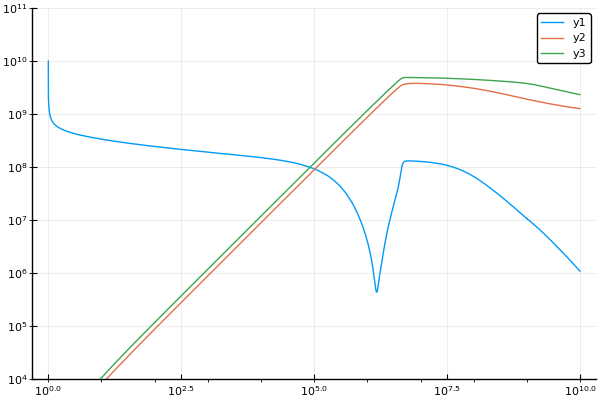

In [103]:
T = map(u->u[1], sol.u);
eta_e = map(u->u[2]/kB, sol.u);
eta_mu = map(u->u[3]/kB, sol.u);
plot(sol.t, T, scale=:log10)
plot!(sol.t, eta_e, scale=:log10)
plot!(sol.t, eta_mu, scale=:log10)
ylims!(1e4,1e11)

In [104]:
model.gapmodel_n

"b"